In [1]:
using PyCall, PyPlot

rcParams = PyDict(matplotlib["rcParams"])
rcParams["xtick.direction"] = "in"
rcParams["ytick.direction"] = "in"
rcParams["font.size"] = 9
rcParams["figure.dpi"] = 300

300

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


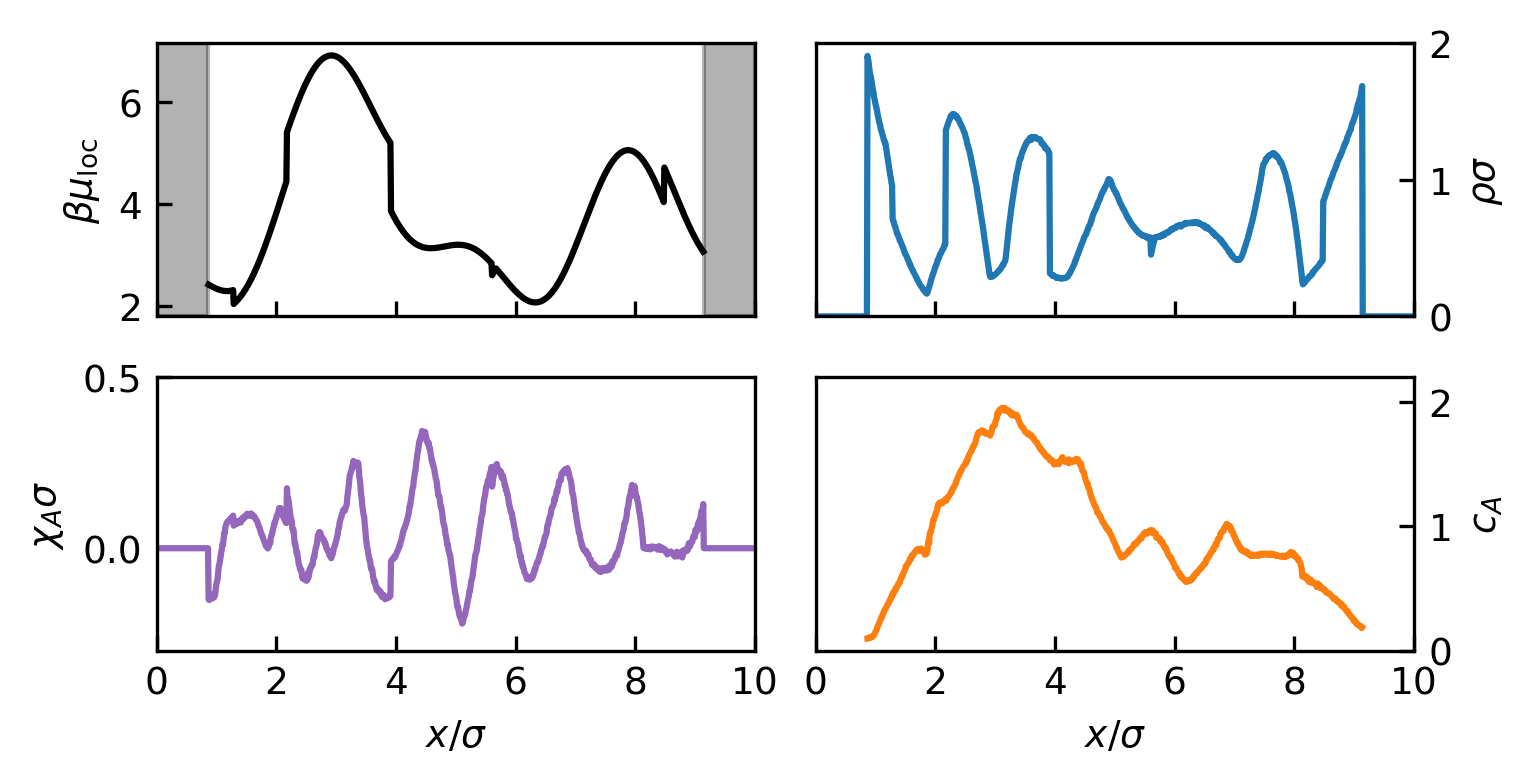

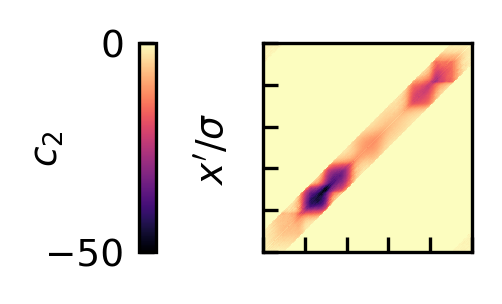

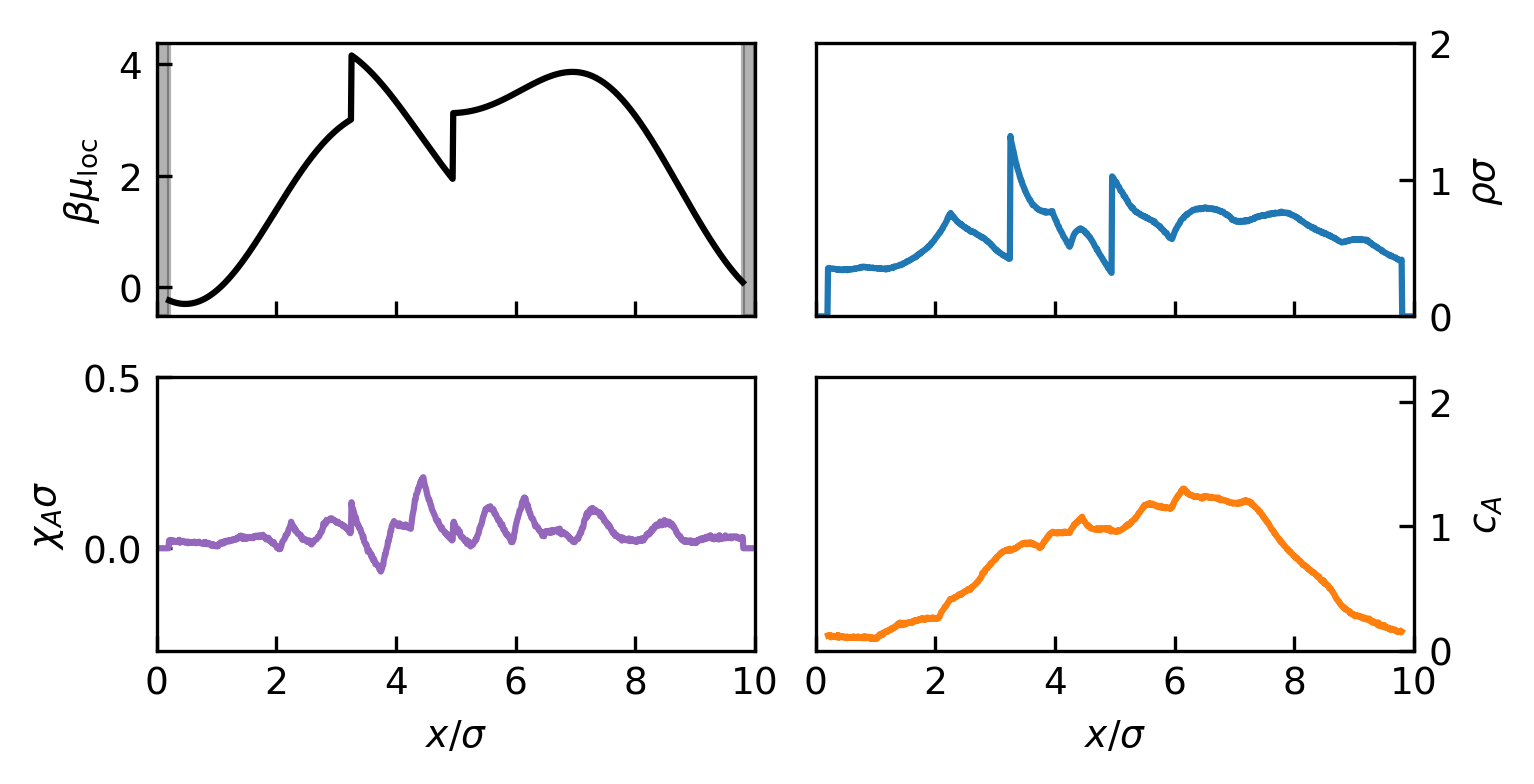

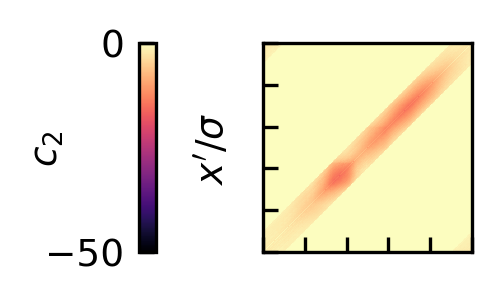

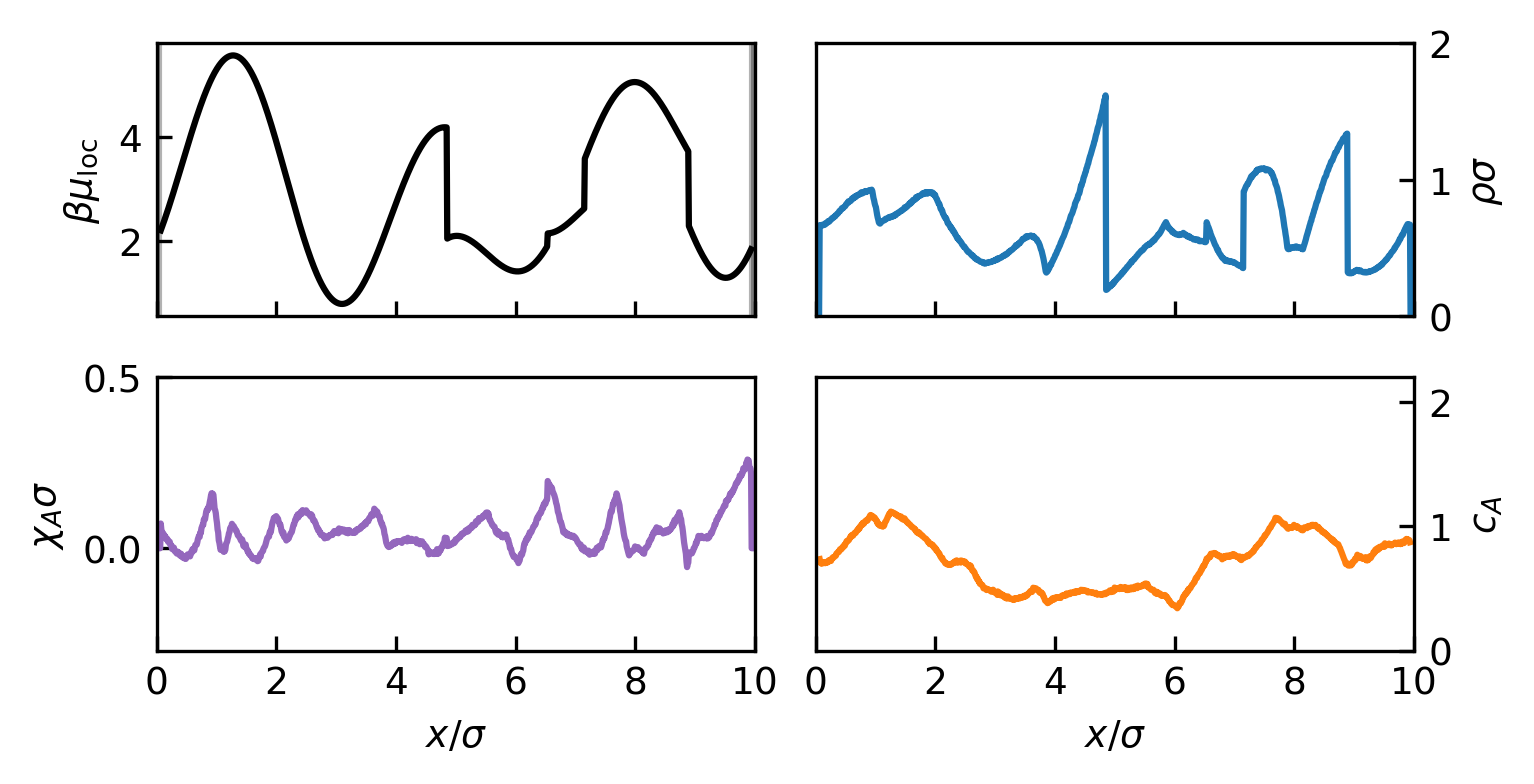

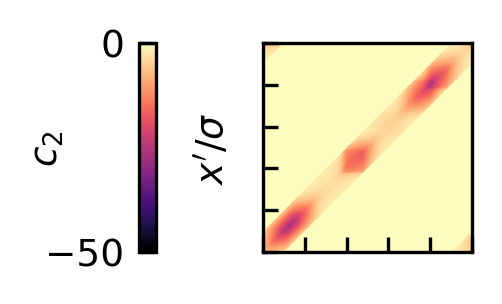

In [2]:
include("dft.jl")
include("neural.jl")

using Flux, BSON, PyCall, PyPlot, LaTeXStrings, DelimitedFiles

for sim_id in [1, 2, 3]
    xs, μloc, ρ, χ_N, χ_cluster = eachcol(readdlm("data_HR_L10_examples/$(sim_id).dat", comments=true))
    
    dx = xs[2] - xs[1]
    BSON.@load "model_HR.bson" model
    c1 = get_c1_neural(model)
    c2 = get_c2_autodiff(c1, xs)
    c2_ρ = c2(ρ)
    c_cluster = χ_cluster ./ ρ .- c2_ρ * χ_cluster * dx
    
    fig, ax = subplots(2, 2, figsize=(5, 2.5), sharex=true, layout="constrained")
    ax[2].set_xlabel(L"$x/\sigma$")
    ax[4].set_xlabel(L"$x/\sigma$")
    ax[end].set_xlim(0, 10)
    ax[1].set_ylabel(L"$\beta \mu_\mathrm{loc}$")
    ax[2].set_ylabel(L"$\chi_A \sigma$")
    ax[2].set_ylim(-0.3, 0.5)
    ax[3].set_ylabel(L"$\rho \sigma$")
    ax[3].set_ylim(0, 2)
    ax[3].yaxis.tick_right()
    ax[3].yaxis.set_label_position("right")
    ax[4].set_ylabel(L"$c_A$")
    ax[4].set_ylim(0, 2.2)
    ax[4].set_yticks([0, 1, 2])
    ax[4].yaxis.tick_right()
    ax[4].yaxis.set_label_position("right")
    
    xwall = xs[.!isinf.(μloc)][1] - dx/2
    ax[1].plot(xs, μloc, color="black")
    ax[1].axvspan(0, xwall, alpha=0.3, color="black")
    ax[1].axvspan(10-xwall, 10, alpha=0.3, color="black")
    ax[2].plot(xs, χ_cluster, color="tab:purple")
    ax[3].plot(xs, ρ, color="tab:blue")
    ax[4].plot(xs, c_cluster, color="tab:orange")
    
    fig.show()
    fig.savefig("figures/profiles_$(sim_id).pdf")
    
    
    fig, ax = subplots(1, 1, figsize=(3, 0.9), layout="constrained")
    
    im = ax.pcolormesh(xs, xs, c2_ρ, cmap="magma", vmin=-50, vmax=0, rasterized=true)
    cbar = fig.colorbar(im, location="left", ax=ax, pad=0.05, aspect=12)
    
    ax.set_aspect("equal")
    ax.set_xticks([0, 2, 4, 6, 8, 10], [])
    ax.set_yticks([0, 2, 4, 6, 8, 10], [])
    ax.set_ylabel(L"x'/\sigma")
    cbar.set_ticks([-50, 0])
    cbar.set_label(L"$c_2$", labelpad=-5)
    
    fig.show()
    fig.savefig("figures/c2_$(sim_id).pdf")
end

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


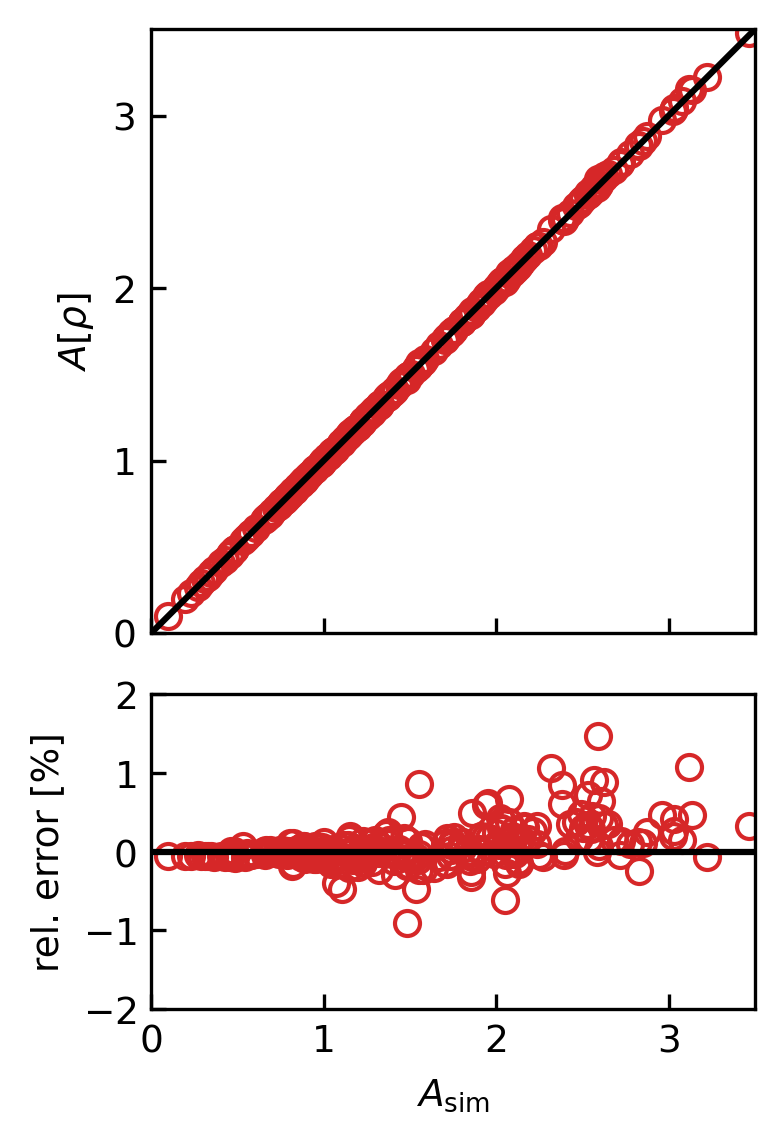

In [3]:
include("neural.jl")
using Flux, BSON, JLD2

function cluster_test_scatter(model_cluster)
    c_cluster = get_c1_neural(model_cluster)
    predictions = []
    references = []
    for i in 1:256
        test_sim = load("data_HR_L10_test/$(i).jld2")
        cluster_prediction = funcintegral(c_cluster, test_sim["xs"], test_sim["ρ"])
        push!(predictions, cluster_prediction)
        push!(references, test_sim["cluster"])
    end
    references, predictions
end

BSON.@load "model_cluster_HR_L10.bson" model_cluster
references, predictions = cluster_test_scatter(model_cluster)

fig, ax = subplots(2, 1, figsize=(2.5, 4), height_ratios=[2, 1], sharex=true, layout="compressed")

ax[1].plot(references, predictions, linestyle="", marker="o", markerfacecolor="none", color="tab:red")
ax[1].plot([0, 10], [0, 10], color="black")
ax[2].plot(references, (predictions .- references) ./ references, linestyle="", marker="o", markerfacecolor="none", color="tab:red")
ax[2].plot([0, 10], [0, 0], color="black")

Amax = 3.5
ax[end].set_xlim(0, Amax)
ax[end].set_xlabel(L"$A_\mathrm{sim}$")
ax[1].set_ylabel(L"$A[\rho]$")
ax[1].set_ylim(0, Amax)
ax[1].set_yticks([0, 1, 2, 3])
ax[1].set_aspect("equal")
ax[2].set_ylabel("rel. error [%]")
ax[2].set_ylim(-0.02, 0.02)
ax[2].set_yticks([-0.02, -0.01, 0, 0.01, 0.02], [L"-2", L"-1", L"0", L"1", L"2"])

fig.show()
fig.savefig("figures/scatter.pdf")

In [ ]:
include("simulation.jl")

using Dates, JLD2

L = 10
T = 1.0
μ = 2.0
xwall = 1.0
Vext(x) = x < xwall || x > L - xwall ? Inf : 0

ϕ_HR(r) = r < 1 ? Inf : 0

function ϕ_SW(r)
    if r < 1
        return Inf
    end
    if r < 1.2
        return -1
    end
    0
end

results_HR = simulate(L, μ, T, Vext, ϕ_HR; equilibration_time=Dates.Second(30), production_time=Dates.Second(600))
jldsave("application_comparison/HR.jld2"; results=results_HR)
results_SW = simulate(L, μ, T, Vext, ϕ_SW; equilibration_time=Dates.Second(30), production_time=Dates.Second(600))
jldsave("application_comparison/SW1.2.jld2"; results=results_SW)

Converged (step: 262, ‖Δρ‖ = 5.9202313e-5 < 6.103515625e-5 = tolerance)
0.6376968765258789
Converged (step: 246, ‖Δρ‖ = 6.017089e-5 < 6.103515625e-5 = tolerance)
1.2590974426269532
Converged (step: 390, ‖Δρ‖ = 6.043911e-5 < 6.103515625e-5 = tolerance)
1.9931027221679687
1.9887955350980524
Converged (step: 268, ‖Δρ‖ = 5.9776008e-5 < 6.103515625e-5 = tolerance)
0.682580337524414
Converged (step: 290, ‖Δρ‖ = 6.0021877e-5 < 6.103515625e-5 = tolerance)
1.7241128540039063
Converged (step: 560, ‖Δρ‖ = 6.0915947e-5 < 6.103515625e-5 = tolerance)
3.2227935791015625
3.217122687968744


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


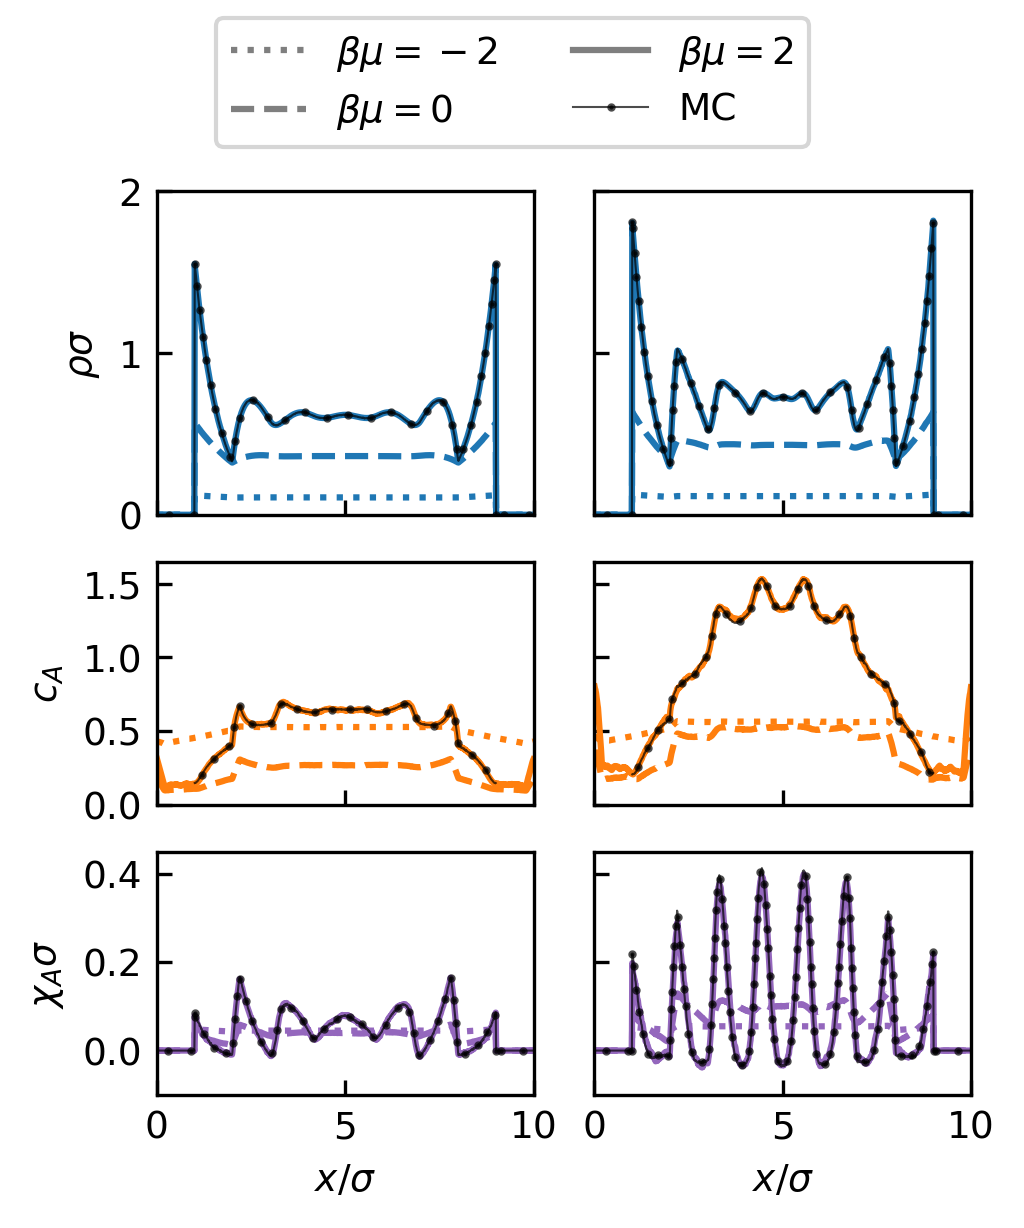

In [4]:
include("simulation.jl")
include("dft.jl")
include("neural.jl")

using BSON, Flux, PyPlot, LaTeXStrings, LinearAlgebra, Printf, Dates, JLD2

L = 10
T = 1.0
dx = 0.01
xwall = 1.0
xs = dx/2:dx:L

μs = [-2, 0, 2]
linestyles = [:dotted, :dashed, :solid]

fig, ax = subplots(3, 2, figsize=(3.3, 4.0), sharex=true, sharey="row", height_ratios=[2, 1.5, 1.5], layout="constrained")

for (p, particles) in enumerate(["HR", "SW1.2"])
    BSON.@load "model_$(particles).bson" model
    BSON.@load "model_cluster_$(particles)_L10.bson" model_cluster
    c1 = get_c1_neural(model)
    c2 = get_c2_autodiff(c1, xs)
    c_cluster = get_c1_neural(model_cluster)
    for i in 1:3
        Vext(x) = x < xwall || x > L - xwall ? Inf : 0
        xs, ρ = minimize(L, μs[i], T, Vext, c1)
        c_A = c_cluster(ρ)
        ax[1,p].plot(xs, ρ, color="tab:blue", linestyle=linestyles[i])
        ax[2,p].plot(xs, c_A, color="tab:orange", linestyle=linestyles[i])
        cluster_prediction = funcintegral(c_cluster, xs, ρ)
        println(cluster_prediction)
        c2_ρ = c2(ρ)
        A_OZ = Diagonal(1 ./ ρ) - c2_ρ * dx
        replace!(A_OZ, Inf=>1000000)
        χ_A = A_OZ \ c_A
        χ_A[ρ .== 0] .= 0
        ax[3,p].plot(xs, χ_A, color="tab:purple", linestyle=linestyles[i])
        if μs[i] == 2.0
            sim_comparison = load("application_comparison/$(particles).jld2")
            results = sim_comparison["results"]
            println(results.scalar["cluster"])
            xs_sim, ρ_sim, χ_N_sim, χ_cluster_sim = results.xs, results.onebody["ρ"], results.onebody["χ_N"], results.onebody["χ_cluster"]
            c2_ρ_sim = c2(ρ_sim)
            c_cluster_sim = χ_cluster_sim ./ ρ_sim .- c2_ρ_sim * χ_cluster_sim * dx
            ax[1,p].plot(xs_sim, ρ_sim, color="black", linewidth=0.5, alpha=0.7, marker=".", markersize=2, markevery=(0.025, 0.05))
            ax[2,p].plot(xs_sim, c_cluster_sim, color="black", linewidth=0.5, alpha=0.7, marker=".", markersize=2, markevery=(0.025, 0.05))
            ax[3,p].plot(xs_sim, χ_cluster_sim, color="black", linewidth=0.5, alpha=0.7, marker=".", markersize=2, markevery=(0.025, 0.05))
        end
    end
end

ax[1,1].set_ylim(0, 2)
ax[1,1].set_ylabel(L"\rho \sigma")
ax[1,1].set_yticks([0, 1, 2])
ax[2,1].set_ylim(0, 1.65)
ax[2,1].set_ylabel(L"c_A")
ax[2,1].set_yticks([0, 0.5, 1, 1.5])
ax[3,1].set_ylim(-0.1, 0.45)
ax[3,1].set_ylabel(L"\chi_A \sigma")
ax[end,1].set_xlim(0, L)
ax[end,1].set_xlabel(L"x/\sigma")
ax[end,2].set_xlabel(L"x/\sigma")

fig.legend([
        PyPlot.matplotlib.lines.Line2D([0], [0], color="tab:grey", linestyle=:dotted),
        PyPlot.matplotlib.lines.Line2D([0], [0], color="tab:grey", linestyle=:dashed),
        PyPlot.matplotlib.lines.Line2D([0], [0], color="tab:grey", linestyle=:solid),
        PyPlot.matplotlib.lines.Line2D([0], [0], color="black", linestyle=:solid, linewidth=0.5, alpha=0.7, marker=".", markersize=2)
    ],
    [L"\beta \mu = -2", L"\beta \mu = 0", L"\beta \mu = 2", "MC"],
    loc="outside upper center",
    ncol=2
)

fig.show()
fig.savefig("figures/application.pdf")